In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import os
import sys
sys.path.append('waveglow/')
import numpy as np
import torch
import IPython.display as ipd
from tqdm import tqdm

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import imageio

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

/home/iot11/Desktop/tacotron2/plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/iot11/anaconda3/envs/tacotron2/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/iot11/anaconda3/envs/tacotron2/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/iot11/anaconda3/envs/tacotron2/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/iot11/anaconda3/envs/tacotron2/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/iot11/anaconda3/envs/tacotron2/lib/python3.6/site-packages/

In [2]:
text = "There is a way to measure the acute emotional intelligence that has never gone out of style."
outdir = "timelapse"
save_audio = True
checkpoints_dir = "outdir"
waveglow_path = 'waveglow_256channels_universal_v5.pt'

In [3]:
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()

/home/iot11/anaconda3/envs/tacotron2/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/iot11/anaconda3/envs/tacotron2/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/iot11/anaconda3/envs/tacotron2/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can r

In [4]:
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()

In [5]:
hparams = create_hparams()
hparams.sampling_rate = 22050
model = load_model(hparams)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Produce results for each checkpoint

In [6]:
checkpoints = [f for f in os.listdir(checkpoints_dir) if os.path.isfile(os.path.join(checkpoints_dir,f))]
total_checkpoints = len(checkpoints)
print(total_checkpoints)

702


  7%|▋         | 52/702 [02:43<33:43,  3.11s/it] 

Warning! Reached max decoder steps


 10%|▉         | 67/702 [03:37<36:32,  3.45s/it]

Warning! Reached max decoder steps


 16%|█▌        | 110/702 [06:10<35:19,  3.58s/it]

Warning! Reached max decoder steps


 16%|█▌        | 111/702 [06:14<37:50,  3.84s/it]

Warning! Reached max decoder steps


 21%|██        | 145/702 [08:20<34:43,  3.74s/it]

Warning! Reached max decoder steps


 23%|██▎       | 163/702 [09:31<35:14,  3.92s/it]

Warning! Reached max decoder steps


 37%|███▋      | 258/702 [16:00<31:13,  4.22s/it]

Warning! Reached max decoder steps


 37%|███▋      | 262/702 [16:18<32:12,  4.39s/it]

Warning! Reached max decoder steps


 51%|█████     | 356/702 [23:22<27:38,  4.79s/it]

Warning! Reached max decoder steps


 58%|█████▊    | 404/702 [27:15<24:27,  4.93s/it]

Warning! Reached max decoder steps


 65%|██████▍   | 454/702 [31:29<21:11,  5.13s/it]

Warning! Reached max decoder steps


 70%|███████   | 492/702 [34:48<18:31,  5.29s/it]

Warning! Reached max decoder steps


 71%|███████   | 495/702 [35:04<18:14,  5.29s/it]

Warning! Reached max decoder steps


 90%|█████████ | 633/702 [48:00<06:47,  5.91s/it]

Warning! Reached max decoder steps


 92%|█████████▏| 644/702 [49:06<05:46,  5.97s/it]

Warning! Reached max decoder steps


 92%|█████████▏| 645/702 [49:12<05:37,  5.92s/it]

Warning! Reached max decoder steps


 93%|█████████▎| 650/702 [49:42<05:11,  5.99s/it]

Warning! Reached max decoder steps


 98%|█████████▊| 687/702 [53:29<01:31,  6.12s/it]

Warning! Reached max decoder steps


100%|██████████| 702/702 [55:03<00:00,  4.71s/it]


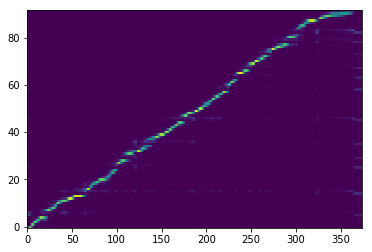

In [7]:
for checkpoint in tqdm(checkpoints):
    model.load_state_dict(torch.load(os.path.join(checkpoints_dir, checkpoint))['state_dict'])
    _ = model.cuda().eval().half()
    
    _, mel_outputs_postnet, _, alignments = model.inference(sequence)
    
    fig = plt.imshow(alignments.float().data.cpu().numpy()[0].T, aspect='auto', origin='bottom', interpolation='none')
    plt.savefig(os.path.join(outdir, f'{checkpoint}.png'))
    
    if save_audio:
        with torch.no_grad():
            audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)

        audio = audio[0].data.cpu().numpy()
        audio = ipd.Audio(audio, rate=hparams.sampling_rate)
        with open(os.path.join(outdir, f'{checkpoint}.wav'), 'wb') as f:
            f.write(audio.data)

# Generate timelapse

In [8]:
images = []

for i in range(0, total_checkpoints*1000, 1000):
    print(i)
    img = Image.open(os.path.join(outdir, f"checkpoint_{i}.png"))
    draw = ImageDraw.Draw(img)
    draw.text((220, 20),str(i),(0,0,0))
    images.append(img)

imageio.mimsave(os.path.join(outdir, "timelapse.gif"), images)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
